# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\hp\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#  [2] Exploratory Data Analysis

We already done EDA and prepossing of data and stored it in final.sqlite. This we will use it directly so now we don't need to do EDA and preprocessing. In Preprocessing section, we are going to use our saved final.sqlite directly.

#  [3] Preprocessing

In [2]:
#loading preprocessed data which was stored in final dataset
con = sqlite3.connect('final.sqlite') 

In [3]:
cleaned_data = pd.read_sql_query("select * from Reviews", con)
cleaned_data.shape

(364171, 12)

In [4]:
cleaned_data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


In [5]:
cleaned_data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [6]:
# To randomly sample 100k points from both class
random_sample_data = cleaned_data.sample(n=100000) 
random_sample_data.shape

(100000, 12)

In [7]:
# Sort data based on time
final_sorted_time=random_sample_data.sort_values('Time',ascending=True,axis=0)
final_sorted_time.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...
261,346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,1,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,b'happen say name three time michael keaten st...
242,1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,b'receiv shipment could hard wait tri product ...


In [8]:
text=final_sorted_time['CleanedText'][0:100000]
text.shape

(100000,)

In [14]:
text

423       b'beetlejuic excel funni movi keaton hilari wa...
261       b'happen say name three time michael keaten st...
242       b'receiv shipment could hard wait tri product ...
485       b'recent purchas woodstream corp gopher trap w...
837       b'much easier use wilson past color color vibr...
845       b'dont know anyon would ever use littl liquid ...
342       b'continu amaz shoddi treatment movi get dvd r...
270       b'warn tri trick widescreen format compani mad...
331       b'vacat adam barbara maitland meet demis kill ...
243       b'michael keaton alreadi way major star play g...
1063      b'wine saver great mani way obvious wonder abl...
1030      b'never dissapoint great gadget compani come b...
1118      b'well mayb greatest one best set bring togeth...
355       b'movi first came fifteen year ago father own ...
336       b'like tim burton movi general good one your m...
365       b'let know movi one person favorit ghost movi ...
1112      b'notori earli album camper va

In [11]:
X=text.str.decode('utf-8')

In [12]:
X.shape

(100000,)

In [13]:
X

423       beetlejuic excel funni movi keaton hilari wack...
261       happen say name three time michael keaten star...
242       receiv shipment could hard wait tri product lo...
485       recent purchas woodstream corp gopher trap wit...
837       much easier use wilson past color color vibran...
845       dont know anyon would ever use littl liquid fo...
342       continu amaz shoddi treatment movi get dvd rel...
270       warn tri trick widescreen format compani made ...
331       vacat adam barbara maitland meet demis kill lo...
243       michael keaton alreadi way major star play gho...
1063      wine saver great mani way obvious wonder abl o...
1030      never dissapoint great gadget compani come bro...
1118      well mayb greatest one best set bring togeth e...
355       movi first came fifteen year ago father own vi...
336       like tim burton movi general good one your mov...
365       let know movi one person favorit ghost movi sa...
1112      notori earli album camper van 

# [4] Featurization

## [4.1] TF-IDF

In [15]:
tfidf_vect = TfidfVectorizer()
data_tf = tfidf_vect.fit_transform(text)

# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [16]:
sorted_features = np.argsort(tfidf_vect.idf_[::-1])
features = tfidf_vect.get_feature_names()

top_features = [features[i] for i in sorted_features[:2000]]

In [18]:
len(top_features)

2000

In [19]:
top_features

['lilikoi',
 'caribe',
 'pancreat',
 'latino',
 'overdid',
 'powercaf',
 'hair',
 'felida',
 'bamag',
 'bonanza',
 'pefer',
 'kool',
 'ake',
 'thern',
 'bruschett',
 'environment',
 'wile',
 'imperson',
 'rooki',
 'guilt',
 'wiska',
 'prestigi',
 'reship',
 'figi',
 'underdon',
 'let',
 'raclettestub',
 'antifung',
 'pomergrant',
 'squirr',
 'cicada',
 'uncultiv',
 'mif',
 'ener',
 'caption',
 'shaox',
 'aerolatt',
 'valiant',
 'leaner',
 'prelud',
 'aram',
 'plumpest',
 'pato',
 'rigth',
 'extractish',
 'cesaer',
 'nooti',
 'toull',
 'appeal',
 'intern',
 'trachea',
 'govida',
 'bustello',
 'kuerig',
 'receptc',
 'toriani',
 'aldi',
 'seeler',
 'diamant',
 'howev',
 'busybe',
 'chickpz',
 'homestyl',
 'crowel',
 'malnutris',
 'proov',
 'smh',
 'satan',
 'bisquitssometim',
 'appliqu',
 'laver',
 'twitchi',
 'splinteri',
 'shute',
 'dunn',
 'tecoski',
 'citral',
 'kirsh',
 'hoop',
 'gblack',
 'yougart',
 'mass',
 'styrofoamish',
 'gow',
 'roughest',
 'paella',
 'alon',
 'catalyz',
 'rab

### [5.2] Calulation of Co-occurrence matrix

In [20]:
from tqdm import tqdm
n_neighbor = 5
occ_matrix = np.zeros((2000,2000))
for row in tqdm(X):
    words_in_row = row.split()
    for index,word in enumerate(words_in_row):
        if word in top_features:
            for j in range(max(index-n_neighbor,0),min(index+n_neighbor,len(words_in_row)-1) + 1):
                if words_in_row[j] in top_features:
                    occ_matrix[top_features.index(word),top_features.index(words_in_row[j])] += 1
                else:
                    continue
        else:
            continue

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [07:22<00:00, 225.93it/s]


In [21]:
occ_matrix

array([[ 3.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 16., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  2.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  2.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  2.]])

### [5.3] Finding optimal value for number of components (n) to be retained.

In [22]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
svd = TruncatedSVD(n_components = 1000)
svd_2000 = svd.fit_transform(occ_matrix)

In [23]:
#cum=np.cumsum(svd.explained_variance_ratio_)
percentage_var_explained = svd.explained_variance_ / np.sum(svd.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)

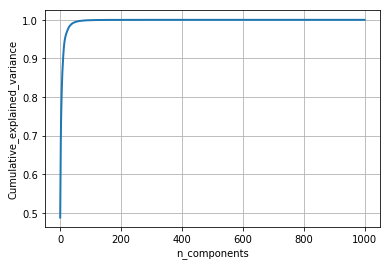

In [24]:
plt.figure(figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

From above graph, we can observe that only 80 components can explain almost 99% of variance . So, it will be good to use only 80 components instead of total 1000 components .

In [25]:
svd = TruncatedSVD(n_components = 80)
svd_2000 = svd.fit_transform(occ_matrix)

### [5.4] Applying k-means clustering

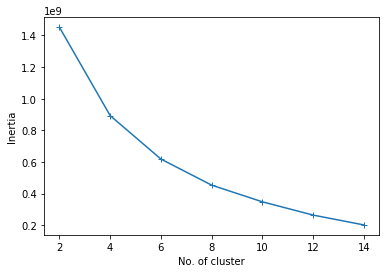

In [26]:
clusters = [2,4,6,8,10,12,14]
from sklearn.cluster import KMeans
dic = {}
for i in clusters:
    clus = KMeans(n_clusters = i)
    clus.fit(svd_2000)
    dic[i] = clus.inertia_
plt.plot(list(dic.keys()), list(dic.values()),'-+')
plt.xlabel("No. of cluster")
plt.ylabel("Inertia")
plt.show()

From above graph, we can observe that no.of cluster having 8 is optimal using elbow method.

In [27]:
model = KMeans(n_clusters = 8)
p = model.fit(svd_2000)

In [29]:
X1=text.values

In [30]:
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []
cluster8 = []

for i in range(p.labels_.shape[0]):
    if p.labels_[i] == 0:
        cluster1.append(X1[i])
    elif p.labels_[i] == 1:
        cluster2.append(X1[i])
    elif p.labels_[i] == 2:
        cluster3.append(X1[i])
    elif p.labels_[i] == 3:
        cluster4.append(X1[i])
    elif p.labels_[i] == 4:
        cluster5.append(X1[i])
    elif p.labels_[i] == 5:
        cluster6.append(X1[i])
    elif p.labels_[i] == 6:
        cluster7.append(X1[i])
    else :
        cluster8.append(X1[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))
print("\nNo. of reviews in Cluster-6 : ",len(cluster6))
print("\nNo. of reviews in Cluster-7 : ",len(cluster7))
print("\nNo. of reviews in Cluster-8 : ",len(cluster8))

No. of reviews in Cluster-1 :  1993

No. of reviews in Cluster-2 :  1

No. of reviews in Cluster-3 :  1

No. of reviews in Cluster-4 :  1

No. of reviews in Cluster-5 :  1

No. of reviews in Cluster-6 :  1

No. of reviews in Cluster-7 :  1

No. of reviews in Cluster-8 :  1


### [5.5] Wordclouds of clusters obtained in the above section

In [31]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    
    
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

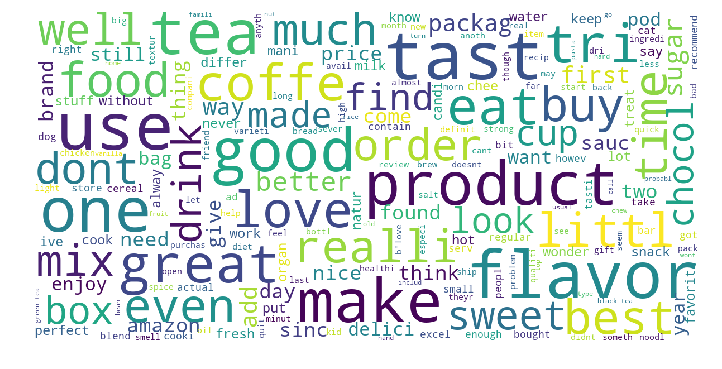

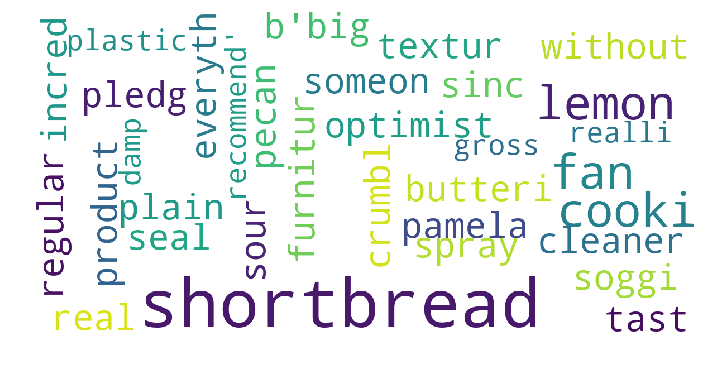

In [32]:
show_wordcloud(cluster1)
show_wordcloud(cluster2)

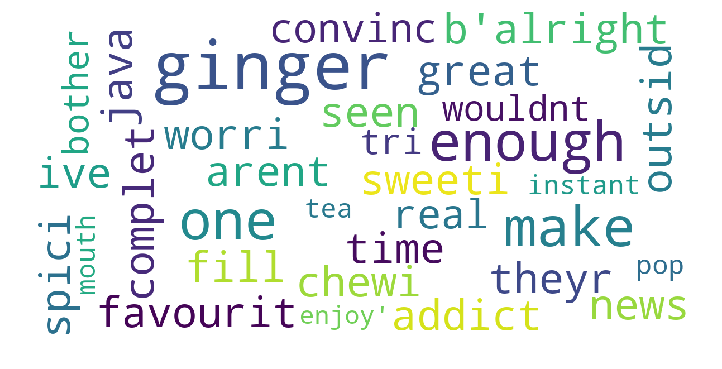

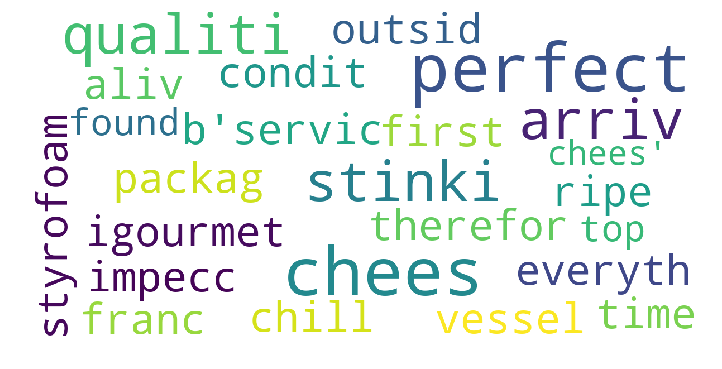

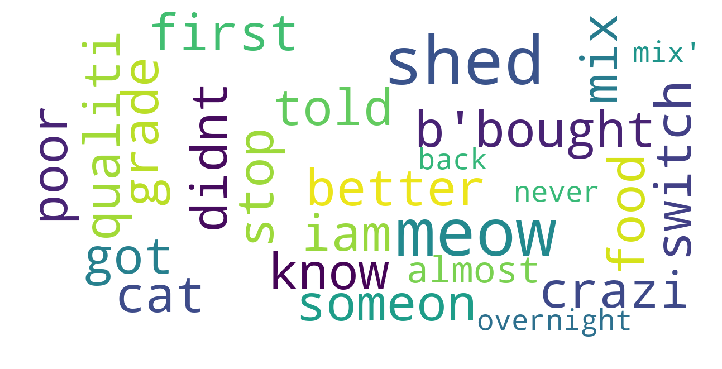

In [33]:
show_wordcloud(cluster3)
show_wordcloud(cluster4)
show_wordcloud(cluster5)

### [5.6] Function that returns most similar words for a given word.

In [34]:
from sklearn.metrics.pairwise import cosine_similarity
def similar_word_10(word):
    similarity = cosine_similarity(occ_matrix)
    word_vect = similarity[top_features.index(word)]
    print("Similar Word to",word)
    index = word_vect.argsort()[::-1][1:11]
    for j in range(len(index)):
        print((j+1),"Word",top_features[index[j]] ,"is similar to",word,"\n")

In [41]:
similar_word_10(top_features[6])

Similar Word to hair
1 Word frizzi is similar to hair 

2 Word preshampoo is similar to hair 

3 Word decoct is similar to hair 

4 Word sud is similar to hair 

5 Word excers is similar to hair 

6 Word overdri is similar to hair 

7 Word nutrium is similar to hair 

8 Word nappi is similar to hair 

9 Word strengthen is similar to hair 

10 Word lifeless is similar to hair 



# [6] Conclusions

* We have taken top 2000 features based on idf values.
* Constructed a Co-occurance Matrix with help of these 2000 features
* Then applied Truncated SVD on co-occurance matrix with optimal no. of components.
* Kmeans on truncated SVD to analyse the clusters.
* Plotted the Word Cloud having cluster=8 to analyse what type of words it contain.

1) Optimal no. of component = 80 where 80 components can explain almost 99% of variance . So, I picked only 80 components instead of total 1000 components using elbow method
2) Optimal cluster = 8.